# Homomorphic Encrpytion for PathMNIST Dataset
---

## Importing libraries and defining global variables

In [ ]:
# if in devices with cuda, install GPU supported Concrete
# !pip uninstall concrete-python
# !pip install concrete-python --extra-index-url https://pypi.zama.ai/gpu.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts

import torchvision.transforms as tt
from torch.utils.data import DataLoader, Dataset

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from tqdm.auto import tqdm

import os
import time
import pickle
from torchinfo import summary

from PIL import Image

torch.manual_seed(0)
np.random.seed(0)

In [3]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
    
ROOT = '.data/'

In [4]:
num_workers = 0
pin_memory = True

In [5]:
SUBSET = 0.5

# Arbitrarily chosen placeholder for normalization
PATH_MNIST_MEAN = [0.5]
PATH_MNIST_STD = [0.5]


BATCH_SIZE = 512
NUM_CLASSES = 9

## Dataset preparation

In [6]:
class PathMNIST(Dataset):

    def __init__(self,
                 split='train',
                 transforms=None,
                 target_transform=None,
                 download=False):
        ''' dataset
        :param split: 'train', 'val' or 'test', select subset
        :param transform: data transformation
        :param target_transform: target transformation

        '''

        # Check if file exists, otherwise try to download if requested
        file_path = os.path.join(ROOT, 'pathmnist.npz')
        if not os.path.exists(file_path):
            if download:
                self._download()
            else:
                raise RuntimeError(
                    f'Dataset not found at {file_path}. Use download=True to download it.')

        # Load dataset
        npz_file = np.load(file_path)

        self.split = split
        self.transforms = transforms
        self.transform_index = 0
        self.target_transform = target_transform

        if self.split == 'train':  # 89996 images
            X_train = npz_file['train_images']
            Y_train = npz_file['train_labels']
            
            end_idx = int(len(X_train) * SUBSET)
            
            self.img = X_train[:end_idx]
            self.label = Y_train[:end_idx]
            
        elif self.split == 'val':  # 10004  images
            X_val = npz_file['val_images']
            Y_val = npz_file['val_labels']
            
            self.img = X_val
            self.label = Y_val
            
        elif self.split == 'test':  # 7180 images
            X_test = npz_file['test_images']
            Y_test = npz_file['test_labels']
            
            self.img = X_test
            self.label = Y_test

    def __getitem__(self, index):
        img, target = self.img[index], self.label[index].astype(int)[0]
        img = Image.fromarray(np.uint8(img))

        if self.transforms is not None:
            img = self.transforms[self.transform_index](img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return self.img.shape[0]

In [7]:
light_transform = tt.Compose([
    tt.ToTensor(),
    tt.Normalize(mean=PATH_MNIST_MEAN, std=PATH_MNIST_STD)
])

In [8]:
train_ds    = PathMNIST(split='train', transforms=[light_transform])
val_ds      = PathMNIST(split='val', transforms=[light_transform])
test_ds     = PathMNIST(split='test', transforms=[light_transform])

In [9]:
train_dl    = DataLoader(train_ds, 512, 
                         shuffle=True,
                         num_workers=num_workers, 
                         pin_memory=pin_memory)

test_dl     = DataLoader(test_ds, 512, 
                         False, 
                         num_workers=num_workers, 
                         pin_memory=pin_memory)

val_dl      = DataLoader(val_ds, 512, 
                         False, 
                         num_workers=num_workers, 
                         pin_memory=pin_memory)

In [10]:
next(iter(train_dl))

[tensor([[[[ 0.5922,  0.6627,  0.6078,  ...,  0.4980,  0.5137,  0.5765],
           [ 0.4980,  0.6000,  0.5294,  ...,  0.4667,  0.4902,  0.4275],
           [ 0.5686,  0.3882,  0.3647,  ...,  0.5451,  0.5451,  0.5608],
           ...,
           [ 0.6392,  0.7961,  0.7647,  ...,  0.5059,  0.5451,  0.6863],
           [ 0.6314,  0.6863,  0.5843,  ...,  0.4039,  0.3804,  0.7412],
           [ 0.5529,  0.6863,  0.6314,  ...,  0.3725,  0.2627,  0.6000]],
 
          [[ 0.3490,  0.4510,  0.3647,  ...,  0.0902,  0.1373,  0.3255],
           [ 0.0667,  0.3176,  0.2078,  ..., -0.0510,  0.0824,  0.0824],
           [ 0.0902, -0.0824, -0.1294,  ...,  0.0118,  0.1294,  0.2863],
           ...,
           [ 0.4431,  0.6627,  0.6235,  ...,  0.0824,  0.0588,  0.3412],
           [ 0.4196,  0.4980,  0.3412,  ..., -0.1686, -0.1294,  0.3961],
           [ 0.2471,  0.4824,  0.3725,  ..., -0.1765, -0.2784,  0.1294]],
 
          [[ 0.6314,  0.6863,  0.6392,  ...,  0.4667,  0.4824,  0.6157],
           [ 

## Model Definition

In [11]:
class BasicConvNet(nn.Module):
    """
    PyTorch implementation of a simple CNN for PathMNIST.
    PathMNIST has RGB images of size 28x28x3.
    """
    def __init__(self, num_classes=9):
        super().__init__()
        
        # First convolutional block
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        
        # Second convolutional block
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        # Third convolutional block
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Pooling layer
        self.pool = nn.MaxPool2d(2)
        
        self.fc = nn.Linear(3*3*64, num_classes)
    
    def forward(self, x):
        # First block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        # Second block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        # Third block
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        
        # Flatten
        x = x.view(x.size(0), -1)
        
        # Fully connected layer
        x = self.fc(x)
        
        return x



## Train Preparation

In [12]:
model = BasicConvNet()
model = model.to(device)

In [13]:
model

BasicConvNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=576, out_features=9, bias=True)
)

In [14]:
summary(model, input_size=(1, 3, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
BasicConvNet                             [1, 9]                    --
├─Conv2d: 1-1                            [1, 64, 28, 28]           1,792
├─BatchNorm2d: 1-2                       [1, 64, 28, 28]           128
├─MaxPool2d: 1-3                         [1, 64, 14, 14]           --
├─Conv2d: 1-4                            [1, 64, 14, 14]           36,928
├─BatchNorm2d: 1-5                       [1, 64, 14, 14]           128
├─MaxPool2d: 1-6                         [1, 64, 7, 7]             --
├─Conv2d: 1-7                            [1, 64, 7, 7]             36,928
├─BatchNorm2d: 1-8                       [1, 64, 7, 7]             128
├─MaxPool2d: 1-9                         [1, 64, 3, 3]             --
├─Linear: 1-10                           [1, 9]                    5,193
Total params: 81,225
Trainable params: 81,225
Non-trainable params: 0
Total mult-adds (M): 10.46
Input size (MB): 0.01
Forward/backward pa

In [15]:
# again, the very strange summary behaviour
model = model.to(device)

In [78]:
opt = SGD(model.parameters(),lr = 1e-3)
criterion = nn.CrossEntropyLoss()

In [79]:
BATCH_SIZE = 512
MAX_PHYSICAL_BATCH_SIZE = 128

In [58]:
def accuracy(preds, labels):
    return (preds == labels).mean()

In [81]:
def train(model, train_loader, optimizer, epoch, device):
    model.train()
    criterion = nn.CrossEntropyLoss()

    losses = []
    top1_acc = []

    for i, (images, target) in enumerate(train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        target = target.to(device)

        # compute output
        output = model(images)
        loss = criterion(output, target)

        preds = np.argmax(output.detach().cpu().numpy(), axis=1)
        labels = target.detach().cpu().numpy()

        # measure accuracy and record loss
        acc = accuracy(preds, labels)

        losses.append(loss.item())
        top1_acc.append(acc)

        loss.backward()
        optimizer.step()

    print(
        f"Epoch {epoch}\n"
        f"\ttrain     Loss: {np.mean(losses):.4f}    Acc: {np.mean(top1_acc) * 100:.4f}%"
    )

    return np.mean(losses), np.mean(top1_acc)

In [82]:
def test(model, test_loader, device):
    model.eval()
    criterion = nn.CrossEntropyLoss()
    losses = []
    top1_acc = []

    with torch.no_grad():
        for images, target in test_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)
            preds = np.argmax(output.detach().cpu().numpy(), axis=1)
            labels = target.detach().cpu().numpy()
            acc = accuracy(preds, labels)

            losses.append(loss.item())
            top1_acc.append(acc)

    top1_avg = np.mean(top1_acc)

    print(
        f"\tval       Loss: {np.mean(losses):.4f}    Acc: {top1_avg * 100:.4f}%"
    )
    return np.mean(losses), np.mean(top1_acc)

In [83]:
train_losses = []
train_accuracies = []

val_losses = []
val_accuracies = []

EPOCHS = 100
for epoch in tqdm(range(EPOCHS), desc="Epoch", unit="epoch"):
    loss, acc = train(model, train_dl, opt, epoch + 1, device)
    val_loss,val_acc = test(model, val_dl, device)
    
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]

Epoch 1
	train     Loss: 1.8258    Acc: 36.7259%
	val       Loss: 1.5756    Acc: 46.3755%
Epoch 2
	train     Loss: 1.4531    Acc: 50.4792%
	val       Loss: 1.3637    Acc: 53.0619%
Epoch 3
	train     Loss: 1.2897    Acc: 55.9210%
	val       Loss: 1.2405    Acc: 57.2915%
Epoch 4
	train     Loss: 1.1873    Acc: 59.0995%
	val       Loss: 1.1545    Acc: 60.1987%
Epoch 5
	train     Loss: 1.1151    Acc: 62.0964%
	val       Loss: 1.0927    Acc: 62.8143%
Epoch 6
	train     Loss: 1.0604    Acc: 64.2642%
	val       Loss: 1.0456    Acc: 64.9639%
Epoch 7
	train     Loss: 1.0178    Acc: 65.8177%
	val       Loss: 1.0063    Acc: 65.6894%
Epoch 8
	train     Loss: 0.9820    Acc: 66.8786%
	val       Loss: 0.9751    Acc: 66.9380%
Epoch 9
	train     Loss: 0.9518    Acc: 67.9280%
	val       Loss: 0.9456    Acc: 67.9215%
Epoch 10
	train     Loss: 0.9247    Acc: 68.8446%
	val       Loss: 0.9219    Acc: 68.7794%
Epoch 11
	train     Loss: 0.9012    Acc: 69.5638%
	val       Loss: 0.8984    Acc: 69.1994%
Epoch 12

In [89]:
torch.save(model, 'checkpoints/baseline_model.pth')
torch.save(model.state_dict(), 'checkpoints/baseline_model_state_dict.pth')

In [90]:
_ , _ = test(model, test_dl, device)

	val       Loss: 0.7089    Acc: 81.8229%


## Train Evaluation

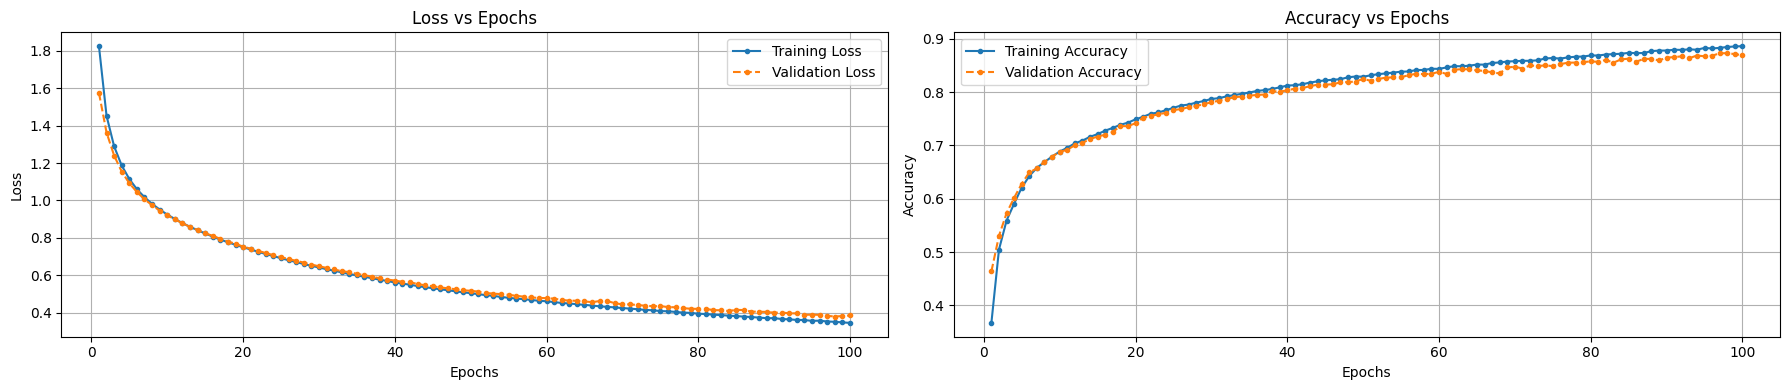

In [88]:
def plot_training_curves(metrics1: dict, metrics2: dict, label1='Model 1', label2='Model 2'):
    """
    Plots Loss vs Epochs and Accuracy vs Epochs for two sets of metrics.

    Parameters:
    - metrics1: dict with keys 'loss' and 'accuracy' for the first model.
    - metrics2: dict with keys 'loss' and 'accuracy' for the second model.
    - label1: Label for the first model (default: 'Model 1').
    - label2: Label for the second model (default: 'Model 2').
    """
    epochs = np.arange(1, len(metrics1['loss']) + 1)

    plt.figure(figsize=(18, 4))

    # Plot Loss vs Epochs
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics1['loss'], label=f'{label1} Loss', marker='.', linestyle='-')
    plt.plot(epochs, metrics2['loss'], label=f'{label2} Loss', marker='.', linestyle='--')
    plt.title('Loss vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy vs Epochs
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics1['accuracy'], label=f'{label1} Accuracy', marker='.', linestyle='-')
    plt.plot(epochs, metrics2['accuracy'], label=f'{label2} Accuracy', marker='.', linestyle='--')
    plt.title('Accuracy vs Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Example usage:
# Replace these arrays with your actual data
train = {
    'loss': train_losses,
    'accuracy': train_accuracies
}

val = {
    'loss': val_losses,
    'accuracy': val_accuracies
}

plot_training_curves(train, val, label1='Training', label2='Validation')


## Concrete (using PTQ)

In [17]:
import concrete.ml as cml
from concrete import fhe
from concrete.ml.torch.compile import compile_torch_model

In [ ]:
if torch.backends.mps.is_available():
    cdevice = 'cpu'
else:
    cdevice = 'cuda'

In [ ]:
print("Converting PyTorch model to Concrete ML...")

model = torch.load("checkpoints/baseline_model.pth").to(cdevice)

# Use a sample input to trace the model
dummy_input = torch.randn(1, 3, 28, 28).to(cdevice)

# Note: Concrete ML uses Post-Training Quantization (PTQ) by default
quantized_module = compile_torch_model(
    model,
    dummy_input,
    n_bits=6, 
    rounding_threshold_bits={"n_bits": 6, "method": "approximate"},
    device = cdevice,
)

print("Model successfully converted to Concrete ML format")

Converting PyTorch model to Concrete ML...
Model successfully converted to Concrete ML format


### Test Concrete with one example

In [49]:
data, target = next(iter(test_dl))
data.shape

torch.Size([512, 3, 28, 28])

In [ ]:
x_test_q = quantized_module.quantize_input(data.numpy())

y_pred_q = quantized_module.quantized_forward(x_test_q, fhe="simulate")
y_pred_q

array([[-1716, -2100,  1630, ...,  2697,   803,  2011],
       [ -859,  2185, -2986, ...,   724,   746,   100],
       [ -416,  1717, -2329, ...,  2355,  -171,  1072],
       ...,
       [ -859,  -980,   265, ...,  2014,   530,  1494],
       [ 3991,  2147, -3289, ...,  1138,   554, -2163],
       [   20, -1302,    84, ...,  2109,  1000,  1778]])

In [51]:
y_pred_q.shape

(512, 9)

In [52]:
y_fhe_pred = quantized_module.dequantize_output(y_pred_q)
y_fhe_pred

array([[-4.23285118, -5.22034781,  4.08824246, ...,  6.73222881,
         1.9653234 ,  4.97441922],
       [-2.10154153,  5.43620041, -7.3914837 , ...,  1.82549143,
         1.82356768,  0.22187227],
       [-0.99982605,  4.27231136, -5.75756254, ...,  5.8816945 ,
        -0.45695851,  2.63918029],
       ...,
       [-2.10154153, -2.43497232,  0.69356607, ...,  5.03364714,
         1.28638812,  3.68866999],
       [ 9.96012915,  5.3416966 , -8.14502725, ...,  2.85508559,
         1.34607474, -5.4060784 ],
       [ 0.08448084, -3.23576777,  0.2434295 , ...,  5.26990667,
         2.45525105,  4.39496163]])

In [53]:
y_plain_pred = model(data)
y_plain_pred

tensor([[-4.5673, -3.5485,  3.1169,  ...,  6.0178,  0.3435,  5.7740],
        [-1.4372,  0.5897, -1.6821,  ...,  1.9655,  1.5347, -0.6311],
        [ 3.9060,  3.4544, -2.9614,  ...,  2.8118, -3.9402, -2.1917],
        ...,
        [-0.0924, -3.7503,  0.7234,  ...,  5.6745, -0.4373,  1.7236],
        [ 1.4205,  7.2826, -3.2965,  ..., -0.0205, -4.6725, -0.7658],
        [-2.4499, -3.8247,  1.8770,  ...,  4.4735,  0.8730,  3.1130]],
       grad_fn=<AddmmBackward0>)

In [54]:
np.argmax(y_fhe_pred, axis=1)

array([6, 4, 4, 6, 4, 4, 8, 0, 6, 8, 8, 6, 8, 6, 0, 8, 0, 5, 0, 8, 5, 0,
       1, 8, 8, 0, 0, 6, 6, 5, 1, 8, 1, 0, 7, 7, 7, 6, 4, 4, 5, 6, 4, 8,
       0, 6, 6, 5, 6, 7, 6, 5, 2, 6, 0, 8, 8, 0, 0, 0, 4, 4, 4, 0, 8, 2,
       4, 0, 8, 4, 0, 8, 0, 6, 8, 8, 5, 7, 7, 5, 8, 5, 4, 0, 8, 8, 4, 0,
       0, 4, 8, 0, 8, 0, 6, 4, 8, 0, 5, 8, 8, 6, 8, 6, 2, 2, 4, 0, 6, 8,
       4, 0, 6, 1, 8, 6, 7, 0, 8, 4, 0, 4, 2, 8, 4, 0, 8, 8, 4, 5, 0, 8,
       8, 0, 8, 4, 4, 5, 8, 5, 8, 6, 8, 8, 4, 0, 8, 5, 6, 6, 7, 5, 0, 4,
       8, 5, 7, 4, 8, 6, 6, 4, 5, 6, 7, 8, 7, 4, 7, 0, 4, 4, 4, 6, 5, 7,
       7, 4, 6, 6, 6, 4, 7, 7, 8, 4, 5, 0, 0, 4, 7, 4, 8, 0, 0, 0, 6, 4,
       4, 5, 0, 4, 8, 4, 8, 0, 5, 6, 6, 8, 6, 4, 8, 5, 4, 6, 8, 0, 6, 6,
       7, 0, 5, 8, 4, 1, 5, 2, 5, 4, 7, 4, 5, 4, 8, 7, 8, 8, 0, 4, 0, 8,
       6, 6, 4, 7, 0, 4, 0, 8, 5, 5, 4, 6, 6, 4, 6, 4, 5, 8, 4, 2, 4, 7,
       0, 2, 0, 6, 4, 0, 5, 6, 4, 8, 0, 8, 6, 8, 6, 8, 8, 4, 5, 4, 8, 0,
       8, 0, 4, 7, 6, 4, 4, 4, 6, 0, 8, 7, 6, 8, 5,

In [55]:
np.argmax(y_plain_pred.detach().numpy(), axis=1)

array([6, 4, 4, 6, 0, 1, 8, 0, 6, 8, 8, 6, 8, 6, 0, 8, 0, 2, 0, 5, 2, 0,
       1, 8, 8, 0, 1, 6, 6, 0, 0, 8, 0, 0, 1, 2, 2, 3, 7, 3, 5, 6, 4, 8,
       0, 3, 6, 2, 6, 7, 3, 1, 3, 3, 0, 1, 2, 0, 0, 0, 4, 4, 4, 0, 8, 3,
       4, 0, 2, 0, 0, 8, 0, 6, 2, 6, 5, 1, 1, 5, 2, 0, 4, 0, 3, 8, 4, 5,
       0, 0, 8, 8, 6, 0, 3, 4, 2, 0, 0, 1, 8, 3, 8, 3, 3, 3, 4, 0, 1, 1,
       4, 0, 1, 1, 5, 3, 1, 0, 8, 4, 0, 4, 2, 8, 4, 5, 8, 1, 4, 5, 0, 8,
       8, 0, 8, 4, 0, 0, 3, 1, 8, 6, 8, 8, 4, 0, 1, 5, 3, 6, 7, 5, 0, 4,
       8, 1, 7, 0, 1, 6, 1, 4, 5, 6, 1, 8, 5, 0, 7, 0, 3, 4, 6, 3, 0, 7,
       2, 6, 8, 6, 8, 0, 5, 7, 8, 0, 1, 0, 0, 4, 2, 4, 8, 5, 0, 0, 8, 2,
       0, 1, 0, 4, 8, 2, 8, 0, 0, 3, 8, 1, 8, 4, 8, 0, 4, 1, 1, 0, 2, 6,
       7, 5, 5, 8, 4, 4, 5, 1, 1, 5, 7, 4, 0, 4, 3, 2, 8, 8, 0, 6, 0, 2,
       3, 6, 0, 5, 0, 4, 0, 8, 5, 3, 4, 6, 3, 0, 3, 4, 1, 8, 0, 3, 4, 7,
       5, 3, 0, 8, 0, 0, 5, 6, 4, 2, 0, 8, 6, 8, 6, 7, 8, 4, 0, 4, 1, 8,
       8, 5, 3, 1, 3, 4, 4, 4, 3, 0, 1, 5, 8, 8, 7,

In [60]:
labels = target.detach().cpu().numpy()

plain_acc = accuracy(np.argmax(y_plain_pred.detach().numpy(), axis=1), labels)
fhe_acc = accuracy(np.argmax(y_fhe_pred, axis=1), labels)

print(plain_acc, fhe_acc)

0.8203125 0.544921875


In [70]:
# Quantize an original float input
q_input = quantized_module.quantize_input(x_test_q)
print(f"\nquantized input: {q_input}")

# Encrypt the input
q_input_enc = quantized_module.fhe_circuit.encrypt(q_input[0:1,:,:,:])
print(f"\nquantized encrypted input: {q_input_enc.serialize().hex()}")

# Execute the linear product in FHE
q_y_enc = quantized_module.fhe_circuit.run(q_input_enc)
print(f"\nquantized encrypted result: {q_y_enc.serialize().hex()}")

# Decrypt the result (integer)
q_y = quantized_module.fhe_circuit.decrypt(q_y_enc)
print(f"\ndecrypted result (still quantized): {q_y}")

# De-quantize and post-process the result
y0 = quantized_module.post_processing(quantized_module.dequantize_output(q_y))
print(f"\ndecrypted, dequantized result: {y0}")

quantized input: [[[[  6  -3 -12 ... -29 -20 -29]
   [  6   6 -12 ... -29 -29 -20]
   [  6   6  -3 ... -20 -20 -12]
   ...
   [-12  -3  -3 ...   6 -12  -3]
   [ -3  -3 -12 ...  -3 -29 -20]
   [-12 -12 -12 ... -12 -20 -20]]

  [[-32 -32 -32 ... -32 -32 -32]
   [-32 -32 -32 ... -32 -32 -32]
   [-32 -32 -32 ... -32 -32 -32]
   ...
   [-32 -32 -32 ... -29 -32 -32]
   [-32 -32 -32 ... -32 -32 -32]
   [-32 -32 -32 ... -32 -32 -32]]

  [[ -3 -12 -20 ... -29 -29 -29]
   [ -3 -12 -20 ... -29 -29 -29]
   [ -3  -3 -12 ... -29 -29 -20]
   ...
   [-20 -12 -20 ...  -3 -12  -3]
   [-12 -20 -20 ... -12 -29 -20]
   [-20 -20 -20 ... -20 -20 -20]]]


 [[[ 14  -3  -3 ...   6  -3  -3]
   [ 14  14  -3 ...   6   6   6]
   [ 14  23   6 ...  -3   6  -3]
   ...
   [ 14   6   6 ... -12  -3   6]
   [  6   6   6 ... -12  -3   6]
   [  6   6   6 ... -12 -12 -12]]

  [[-12 -32 -32 ... -12 -29 -29]
   [ -3 -20 -32 ... -12 -20 -20]
   [-12   6 -29 ... -20 -20 -32]
   ...
   [ -3 -20 -12 ... -32 -29 -20]
   [-12 -20 -2

: 